In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load the dataset for recommenders

In [2]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [3]:
def prepare_users_df(interactions_df):

    users_df = interactions_df.copy()
    users_df = pd.get_dummies(data=users_df, columns=base_item_features, prefix='user')
    users_df = users_df.drop(['item_id'], axis = 1)

    user_features = users_df.columns.to_list()
    user_features.pop(0)
    users_df['val'] = 1
    users_df = users_df.groupby("user_id").sum().reset_index()

    for feature in user_features:
        users_df[feature] = users_df[feature] / users_df['val']
    users_df = users_df.drop(['val'], axis = 1)

    return users_df, user_features

users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['user_WinterVacation', 'user_Easter', 'user_OffSeason', 'user_HighSeason', 'user_LowSeason', 'user_MayLongWeekend', 'user_NewYear', 'user_Christmas', 'user_[0-1]', 'user_[2-3]', 'user_[4-7]', 'user_[8-inf]', 'user_Standard', 'user_Nonref', 'user_[0-160]', 'user_[160-260]', 'user_[260-360]', 'user_[360-500]', 'user_[500-900]', 'user_[1-1]', 'user_[2-2]', 'user_[3-4]', 'user_[5-inf]', 'user_True', 'user_False']


,user_id,user_WinterVacation,user_Easter,user_OffSeason,user_HighSeason,user_LowSeason,user_MayLongWeekend,user_NewYear,user_Christmas,user_[0-1],user_[2-3],user_[4-7],user_[8-inf],user_Standard,user_Nonref,user_[0-160],user_[160-260],user_[260-360],user_[360-500],user_[500-900],user_[1-1],user_[2-2],user_[3-4],user_[5-inf],user_True,user_False
0,1,0.090909,0.0,0.681818,0.090909,0.136364,0.000000,0.000000,0.0,0.000000,0.590909,0.409091,0.000000,0.500000,0.500000,0.000000,0.863636,0.136364,0.0,0.0,0.000000,0.727273,0.181818,0.090909,0.772727,0.227273
40,50,0.043478,0.0,0.434783,0.304348,0.217391,0.000000,0.000000,0.0,0.000000,0.913043,0.086957,0.000000,0.260870,0.739130,0.000000,0.565217,0.434783,0.0,0.0,0.000000,0.173913,0.521739,0.304348,0.782609,0.217391
84,96,0.090909,0.0,0.681818,0.136364,0.045455,0.045455,0.000000,0.0,0.272727,0.636364,0.045455,0.045455,0.272727,0.727273,0.045455,0.863636,0.090909,0.0,0.0,0.045455,0.272727,0.590909,0.090909,0.727273,0.272727
102,115,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,1.000000,0.000000,0.000000,0.500000,0.500000,0.0,0.0,0.500000,0.000000,0.000000,0.500000,0.000000,1.000000
371,706,0.095238,0.0,0.511905,0.190476,0.142857,0.047619,0.011905,0.0,0.297619,0.380952,0.238095,0.083333,0.976190,0.023810,0.035714,0.857143,0.107143,0.0,0.0,0.119048,0.154762,0.583333,0.130952,0.583333,0.416667
1383,1736,0.034483,0.0,0.482759,0.206897,0.275862,0.000000,0.000000,0.0,0.241379,0.551724,0.206897,0.000000,0.172414,0.827586,0.000000,0.931034,0.068966,0.0,0.0,0.379310,0.413793,0.206897,0.000000,0.448276,0.551724
7301,7779,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.250000,0.500000,0.250000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.750000,0.250000,0.750000,0.250000


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [4]:
def prepare_items_df(interactions_df):
    items_df = interactions_df.copy()
    items_df = pd.get_dummies(data=items_df, columns=base_item_features, prefix='item')
    items_df = items_df.drop(['user_id'], axis = 1)
    items_df = items_df.drop_duplicates()
    item_features = items_df.columns.to_list()
    item_features.pop(0)

    return items_df, item_features

items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['item_WinterVacation', 'item_Easter', 'item_OffSeason', 'item_HighSeason', 'item_LowSeason', 'item_MayLongWeekend', 'item_NewYear', 'item_Christmas', 'item_[0-1]', 'item_[2-3]', 'item_[4-7]', 'item_[8-inf]', 'item_Standard', 'item_Nonref', 'item_[0-160]', 'item_[160-260]', 'item_[260-360]', 'item_[360-500]', 'item_[500-900]', 'item_[1-1]', 'item_[2-2]', 'item_[3-4]', 'item_[5-inf]', 'item_True', 'item_False']


,item_id,item_WinterVacation,item_Easter,item_OffSeason,item_HighSeason,item_LowSeason,item_MayLongWeekend,item_NewYear,item_Christmas,item_[0-1],item_[2-3],item_[4-7],item_[8-inf],item_Standard,item_Nonref,item_[0-160],item_[160-260],item_[260-360],item_[360-500],item_[500-900],item_[1-1],item_[2-2],item_[3-4],item_[5-inf],item_True,item_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [5]:
class MyDropoutNet(nn.Module):
    def __init__(self, features, drop_out, neurons, seed=6789):
        torch.manual_seed(seed)
        super(MyDropoutNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(features, neurons),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(neurons, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

class MyHiddenNet(nn.Module):
    def __init__(self, features, hidden_size, seed=6789):
        torch.manual_seed(seed)
        super(MyHiddenNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(features, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

from recommenders.recommender import Recommender


class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """

    def __init__(self, seed=6789, n_neg_per_pos=5, epochs=10, batch_size=100, drop_out=0.5, learning_rate=0.001, neurons=100, optimizer_type="ADAM", net_type='MyDropoutNet'):
        """
        Initialize base recommender params and variables.
        """

        self.model = None
        self.n_neg_per_pos = int(n_neg_per_pos) #tensor long, int error

        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None

        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)

        # You can add more arguments if needed
        self.epochs = int(epochs) #tensor long, int error
        self.batch_size = int(batch_size) #tensor long, int error
        self.drop_out = drop_out
        self.learning_rate = learning_rate
        self.neurons = int(neurons)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.optimizer_type = optimizer_type
        self.net_type = net_type


    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.

        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """

        interactions_df = interactions_df.copy()

        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)

        users_df, user_features = prepare_users_df(interactions_df)

        self.users_df = users_df
        self.user_features = user_features

        items_df, item_features = prepare_items_df(interactions_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]

        # Generate negative interactions

        interactions_df = interactions_df.loc[:, ['user_id', 'item_id']]

        interactions_df.loc[:, 'interacted'] = 1

        # Create a set of positive interaction tuples

        positive_interactions = interactions_df.loc[:, ['user_id', 'item_id']]
        positive_interactions = positive_interactions.to_dict(orient='records')
        positive_interactions = {tuple(interaction.values()): 1 for interaction in positive_interactions}

        user_ids, item_ids = interactions_df.user_id.unique(), interactions_df.item_id.unique()

        negative_interactions = []

        while len(negative_interactions) < self.n_neg_per_pos * len(interactions_df):
            x, y = self.rng.choice(user_ids), self.rng.choice(item_ids)

            negative_interaction = { 'user_id': x, 'item_id': y, 'interacted': 0 }

            if tuple(negative_interaction.values()) not in positive_interactions:
                negative_interactions.append(negative_interaction)

        interactions_df = pd.concat([interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])

        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)

        interactions_df = pd.merge(interactions_df, users_df, on=['user_id'])
        interactions_df = pd.merge(interactions_df, items_df, on=['item_id'])


        x = interactions_df.loc[:, user_features + item_features].values
        y = interactions_df['interacted'].values

        x_size = len(x[0])
        y_size = y.shape[0]

        # Initialize the neural network model

        if(self.net_type == 'MyDropoutNet'):
            self.model = MyDropoutNet(features=x_size, drop_out=self.drop_out, neurons=self.neurons, seed=self.seed)
        else:
            self.model = MyHiddenNet(features=x_size, hidden_size=self.neurons)

        self.loss = torch.nn.MSELoss()

        if(self.optimizer_type == "SGD"):
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Train the model using an optimizer

        for epoch in range(self.epochs):
            # Shuffle the data to reduce potential bias
            indices = torch.randperm(y_size)

            for i in range(0, y_size, self.batch_size):
                # Select batch indices
                batch_indices = indices[i:i+self.batch_size]

                # Prepare batch data
                X_train = torch.tensor(x[batch_indices].astype(np.float32))
                Y_train = torch.tensor(y[batch_indices].astype(np.float32)).reshape(-1, 1)

                # Perform forward pass
                Y_predict = self.model(X_train)

                # Calculate loss
                loss = self.loss(Y_predict, Y_train)

                # Clear gradients
                self.optimizer.zero_grad()

                # Backpropagation
                loss.backward()

                # Update model parameters
                self.optimizer.step()


    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns
        top n_recommendations for each user.

        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations
            for each user.
        :rtype: pd.DataFrame
        """

        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]

        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)

        users_df = users_df.loc[:, 'user_id']
        users_df = pd.merge(users_df, self.users_df, on=[
                            'user_id'], how='left').fillna(0)

        items_df, item_features = prepare_items_df(items_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]

        # Score the items

        recommendations = pd.DataFrame(columns=['user_id', 'item_id', 'score'])

        for ix, user in users_df.iterrows():

            # Calculate the score for the user and every item in items_df

            user_df = user.to_frame().transpose()
            carthesian = pd.merge(items_df, user_df, how='cross')

            x = carthesian.loc[:, user_features + item_features].values

            self.model.eval()
            scores = self.model(torch.tensor(x.astype(np.float32)))
            scores = scores.detach().numpy()[:, 0]

            chosen_ids = np.argsort(-scores)[:n_recommendations]

            recommendations = []
            for item_id in chosen_ids:
                recommendations.append(
                    {
                        'user_id': user['user_id'],
                        'item_id': item_id,
                        'score': scores[item_id]
                    }
                )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat(
                [self.recommender_df, user_recommendations])

        return self.recommender_df

# Quick test of the recommender

In [6]:
items_df = interactions_df.loc[:, ['user_id', 'item_id'] + base_item_features].drop_duplicates()

# Fit method
nn_recommender = NNRecommender()
nn_recommender.fit(interactions_df, None, None)

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id_x,item_id,score,user_id_y,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1.0,55,0.732091,487,OffSeason,[2-3],Nonref,[160-260],[2-2],True
1,1.0,55,0.732091,489,OffSeason,[2-3],Nonref,[160-260],[2-2],True
2,1.0,55,0.732091,494,OffSeason,[2-3],Nonref,[160-260],[2-2],True
3,1.0,55,0.732091,503,OffSeason,[2-3],Nonref,[160-260],[2-2],True
4,1.0,55,0.732091,516,OffSeason,[2-3],Nonref,[160-260],[2-2],True
5,1.0,55,0.732091,518,OffSeason,[2-3],Nonref,[160-260],[2-2],True
6,1.0,55,0.732091,570,OffSeason,[2-3],Nonref,[160-260],[2-2],True
7,1.0,55,0.732091,611,OffSeason,[2-3],Nonref,[160-260],[2-2],True
8,1.0,55,0.732091,619,OffSeason,[2-3],Nonref,[160-260],[2-2],True
9,1.0,55,0.732091,662,OffSeason,[2-3],Nonref,[160-260],[2-2],True


# Tuning method

In [7]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [8]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

In [9]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 20, 1),
    'optimizer_type': hp.choice("optimizer_type",["ADAM","SGD"]),
    'batch_size': hp.quniform('batch_size', 24, 128, 1),
    'neurons': hp.quniform('neurons', 50, 150, 10),
    'learning_rate': hp.quniform('learning_rate', 0.0001, 0.01, 0.0001),
    'epochs': hp.quniform('epochs', 5, 20, 1),
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=300, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

 20%|█▉        | 59/300 [1:47:47<6:34:34, 98.24s/trial, best loss: -0.25222175201015656] 

c:\python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



 59%|█████▉    | 177/300 [4:51:07<3:21:11, 98.14s/trial, best loss: -0.25222175201015656] 

c:\python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



100%|██████████| 300/300 [7:59:41<00:00, 95.94s/trial, best loss: -0.25222175201015656]   


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.058384,0.144263,0.181602,0.267142,0.058384,0.107413,0.122541,0.150037


Best parameters:
{'batch_size': 111.0, 'epochs': 9.0, 'learning_rate': 0.0005, 'n_neg_per_pos': 12.0, 'neurons': 140.0, 'optimizer_type': 0}


# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br>
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

In [16]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 20, 1),
    'batch_size': hp.quniform('batch_size', 24, 128, 1),
    'neurons': hp.quniform('neurons', 50, 150, 10),
    'learning_rate': hp.quniform('learning_rate', 0.0001, 0.01, 0.0001),
    'epochs': hp.quniform('epochs', 5, 20, 1),
    'net_type': 'MyHiddenNet'
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=30, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

  3%|▎         | 1/30 [04:34<2:12:45, 274.67s/trial, best loss: -0.09437156157427]

c:\python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



 33%|███▎      | 10/30 [29:34<53:22, 160.12s/trial, best loss: -0.22852306390181973] 

c:\python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



100%|██████████| 30/30 [1:09:44<00:00, 139.49s/trial, best loss: -0.23952602623783326]


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.060081,0.116768,0.171079,0.255601,0.060081,0.090825,0.113754,0.141638


Best parameters:
{'batch_size': 120.0, 'epochs': 10.0, 'learning_rate': 0.0009000000000000001, 'n_neg_per_pos': 9.0, 'neurons': 50.0}


In [10]:
nn_recommender = NNRecommender(batch_size=111, epochs=9, learning_rate=0.0005, n_neg_per_pos=12, neurons=140, optimizer_type='ADAM')  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.058384,0.144263,0.181602,0.267142,0.058384,0.107413,0.122541,0.150037


In [17]:
nn_hidden_recommender = NNRecommender(batch_size=120, epochs=10, learning_rate=0.0009, n_neg_per_pos=9, neurons=50, optimizer_type='ADAM', net_type='MyHiddenNet')  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_hidden_tts_results = [['NNHiddenRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_hidden_tts_results = pd.DataFrame(
    nn_hidden_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_hidden_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNHiddenRecommender,0.059403,0.144603,0.197217,0.266463,0.059403,0.107203,0.128419,0.150624


In [11]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.044128,0.118805,0.160557,0.223354,0.044128,0.086755,0.104216,0.12437


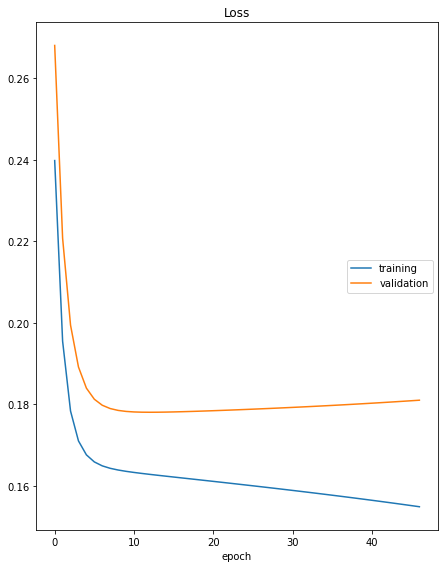

Loss
	training         	 (min:    0.155, max:    0.240, cur:    0.155)
	validation       	 (min:    0.178, max:    0.268, cur:    0.181)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.044128,0.119145,0.161236,0.223354,0.044128,0.086969,0.104561,0.124357


In [13]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=50, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [18]:
tts_results = pd.concat([nn_tts_results, nn_hidden_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.058384,0.144263,0.181602,0.267142,0.058384,0.107413,0.122541,0.150037
1,NNHiddenRecommender,0.059403,0.144603,0.197217,0.266463,0.059403,0.107203,0.128419,0.150624
2,AmazonRecommender,0.044128,0.118805,0.160557,0.223354,0.044128,0.086755,0.104216,0.124370
3,NetflixRecommender,0.044128,0.119145,0.161236,0.223354,0.044128,0.086969,0.104561,0.124357


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

I developed two neural networks:

-<b>MyDropoutNetwork</b>: This network has dropout layer as its main feature.
-<b>MyHiddenNetwork</b>: This network consists of two hidden layers as its main feature.
Both of these neural networks performed well in my project.

At first, I encountered difficulties in generating negative interactions using the same code I wrote in the first project. The scores for HR@10 were consistently low, ranging around 0.05 or 0.02. However, when I changed the method of generating negative interactions according to the feedback I got from first project, I observed a significant improvement in the scores.

I have used two optimizers, SGD and ADAM, but in the end, ADAM worked better with my models.

Unfortunately, while tuning the models, I encountered an error stating that the target size was different from the input size. Due to time constraints, I was unable to fix this error. Nonetheless, I believe that my neural networks performed effectively, despite the potential score inaccuracies introduced by the error.

Given more time, I would have attempted to make a neural network using embedding layers. I believe it would further improve my models
